In [109]:
import sys
import cmocean
import xarray as xr
import numpy as np
import datacube
import geopandas as gpd
import pandas as pd
import itertools
from rasterio import features
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate

# Connect to current collection and collection upgrade databases
dc = datacube.Datacube()

sys.path.append('../10_Scripts')
import DEAPlotting, SpatialTools, DEADataHandling

%load_ext autoreload
%autoreload 2

def level_to_volume(level_m, dem, clip_max=True):
    
    # If water level is above highest point in DEM, use the highest elevation in 
    # the DEM instead of the supplied water level
    if clip_max:
        level_m = np.min([level_m, dem.max().item()])
        
    # Create a flat array with values set to the given water level
    water_level = np.full(dem.shape[1:], level_m)
    
    # Subtract LiDAR DEM from this water level array to create an array giving the 
    # difference between this water level and the true elevation of each pixel
    water_level_diffs = water_level - dem
    
    # By restricting these differences to only pixels where the water level is
    # higher than the underlying LiDAR DEM (i.e. positive values), we can get
    # depths for every pixel
    water_level_depths = water_level_diffs.where(water_level_diffs > 0)
    
    # By multiplying depths by the area of each pixel (obtained from the resolution
    # of the LiDAR raster), we can compute volumes in cubic metres for each pixel
    water_level_volumes = water_level_depths * (lidar_subset.res[0] * lidar_subset.res[1])
    
    # Finally, sum the volumes of all pixels and multiply by 0.001 to get total 
    # waterbody volume in megaliters (Ml) for the given water level height
    total_volume = water_level_volumes.sum().item() * 0.001

    # Append water level height and total volume to list    
    return level_m, total_volume

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set parameters
Note: both the shapefile specified by `waterbody_path` and the LiDAR DEM at `lidar_path` **must have the same CRS / projection**.

In [121]:
name = 'test3'
waterbody_path = '/g/data/r78/rt1527/dea-notebooks/Waterbody_volume/raw_data/waterbody_7.shp'
lidar_path = '/g/data/r78/WaterHack/Lidar/LiDAR_1m_Namoi_NarrabriTown_2014_55.tif'

## Load extent polygon

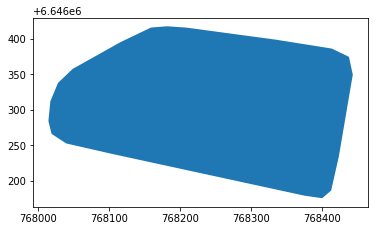

In [122]:
polygon_gdf = gpd.read_file(waterbody_path)
polygon_gdf.plot()

## Load LiDAR data

In [123]:
# Load as an xarray format dataset. The `chunks` option uses dask to break the 
# raster into smaller chunks, and not load any data unless it is requested with
# `.compute()`. This can be useful for large datasets like high-res LiDAR data,
# which will cause memory issues and run very slowly if loaded all in one go.
lidar_data = xr.open_rasterio(lidar_path, chunks={'x': 500, 'y': 500})
lidar_data

<xarray.DataArray (band: 1, y: 26000, x: 32000)>
dask.array<shape=(1, 26000, 32000), dtype=float32, chunksize=(1, 500, 500)>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.654e+06 6.654e+06 6.654e+06 ... 6.628e+06 6.628e+06
  * x        (x) float64 7.52e+05 7.52e+05 7.52e+05 ... 7.84e+05 7.84e+05
Attributes:
    transform:   (1.0, 0.0, 752000.0001220703, 0.0, -1.0, 6654000.00012207)
    crs:         PROJCS["GDA_1994_MGA_Zone_55",GEOGCS["GCS_GDA_1994",DATUM["G...
    res:         (1.0, 1.0)
    is_tiled:    1
    nodatavals:  (-3.402823e+38,)

## Clip and mask LiDAR to extent of polygon

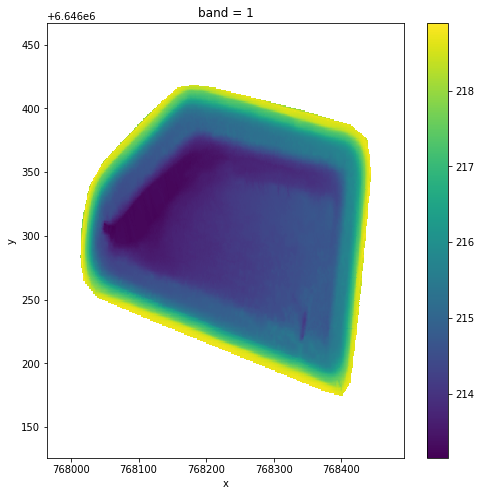

In [124]:
# Clip LiDAR dataset to the extent of the waterbody polygon
lidar_subset = lidar_data.sel(x = (lidar_data.x > polygon_gdf.bounds.minx.item() - 50) & 
                                  (lidar_data.x < polygon_gdf.bounds.maxx.item() + 50),
                              y = (lidar_data.y > polygon_gdf.bounds.miny.item() - 50) & 
                                  (lidar_data.y < polygon_gdf.bounds.maxy.item() + 50))

# Update transform object. This allows us to create a shapefile mask based
# on the extents of the clipped LiDAR dataset
new_transform = list(lidar_data.transform)
new_transform[2] = (lidar_subset.x.min() - lidar_data.transform[0] * 0.5).item()
new_transform[5] = (lidar_subset.y.max() - lidar_data.transform[4] * 0.5).item()
lidar_subset.attrs['transform'] = tuple(new_transform)

# Identify all geometry objects in shapefile
shapes = [(shape, n) for n, shape in enumerate(polygon_gdf.geometry)]

# Generate mask from shapefile
xarray_mask = features.rasterize(shapes, out_shape=lidar_subset.shape[1:],
                                 fill=np.nan, transform=lidar_subset.transform,
                                 all_touched=True, dtype=np.float)

# Load data into memory using `.compute()`
lidar_subset = lidar_subset.compute()
lidar_masked = lidar_subset.where(np.expand_dims(np.isfinite(xarray_mask), axis=0))
lidar_masked.plot(figsize=(8,8))

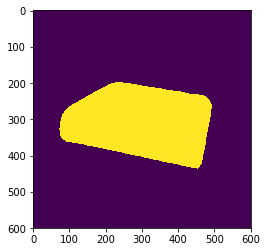

In [126]:
from skimage.measure import label

def extract_dam(dem_path = lidar_path, flood_seed_coords = (6646316.249615, 768246.845872), approx_radius = 300):    
    
    dem = xr.open_rasterio(dem_path, chunks={'x': 500, 'y': 500})

    # Clip LiDAR dataset to the extent of the waterbody polygon
    dem = dem.sel(x = (dem.x > flood_seed_coords[1] - approx_radius) & 
                      (dem.x < flood_seed_coords[1] + approx_radius),
                  y = (dem.y > flood_seed_coords[0] - approx_radius) & 
                      (dem.y < flood_seed_coords[0] + approx_radius))

    # Update transform object. This allows us to create a shapefile mask based
    # on the extents of the clipped LiDAR dataset
    new_transform = list(dem.transform)
    new_transform[2] = (dem.x.min() - dem.transform[0] * 0.5).item()
    new_transform[5] = (dem.y.max() - dem.transform[4] * 0.5).item()
    dem.attrs['transform'] = tuple(new_transform)
    dem = dem.squeeze()
    
    flood_seed = int(len(dem.y) / 2), int(len(dem.x) / 2)

    # Here we 'pour' water from a flood seed location, progressively raising
    # the simulated water level. For each water level, we add any pixels that 
    # are directly connected to the flood seed to a flooding frequency array. 
    # Depending on the DEM, some simulated water may 'spill' from the dam near 
    # the end of the simulation; subsequent steps identify this 'spilling point'
    flood_freq = np.zeros(dem.shape)

    # For all water levels between the elevation of the flood seed and the 
    # max elevation of the DEM:
    for water_level in np.linspace(dem[flood_seed], dem.max(), num=50):

        # Identify all pixels below the flooding level which are directly
        # connected to the flood seed and add these to the flooding freq
        regions = label(dem < water_level, connectivity=1)
        out = regions == regions[flood_seed]
        flood_freq += out

    # First compute histogram of flooding frequency values
    hist, bin_edges = np.histogram(flood_freq, bins=50)
    
    # Find the index of the largest negative slope between each bin 
    # and its previous neighbour. This will identify the "spilling point" 
    # where the simulated flooding first spills over the top of the dam.
    # We want to remove these areas from our dam extent mask.
    min_change = np.argmin(np.gradient(hist, edge_order=1))
    
    # Return the flooding frequency that corresponds with the index of the spilling 
    # point. Any pixels with a flooding frequency greater than this value should
    # be contained completely within the walls of the dam.
    bin_val = bin_edges[min_change]
    dam_extent = flood_freq > bin_val
    
    return dam_extent

plt.imshow(extract_dam())

## Load in Sentinel 2 data

Loading s2a pixel quality
    Loading 72 filtered s2a timesteps
Loading s2b pixel quality
    Loading 58 filtered s2b timesteps
Combining and sorting s2a, s2b data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


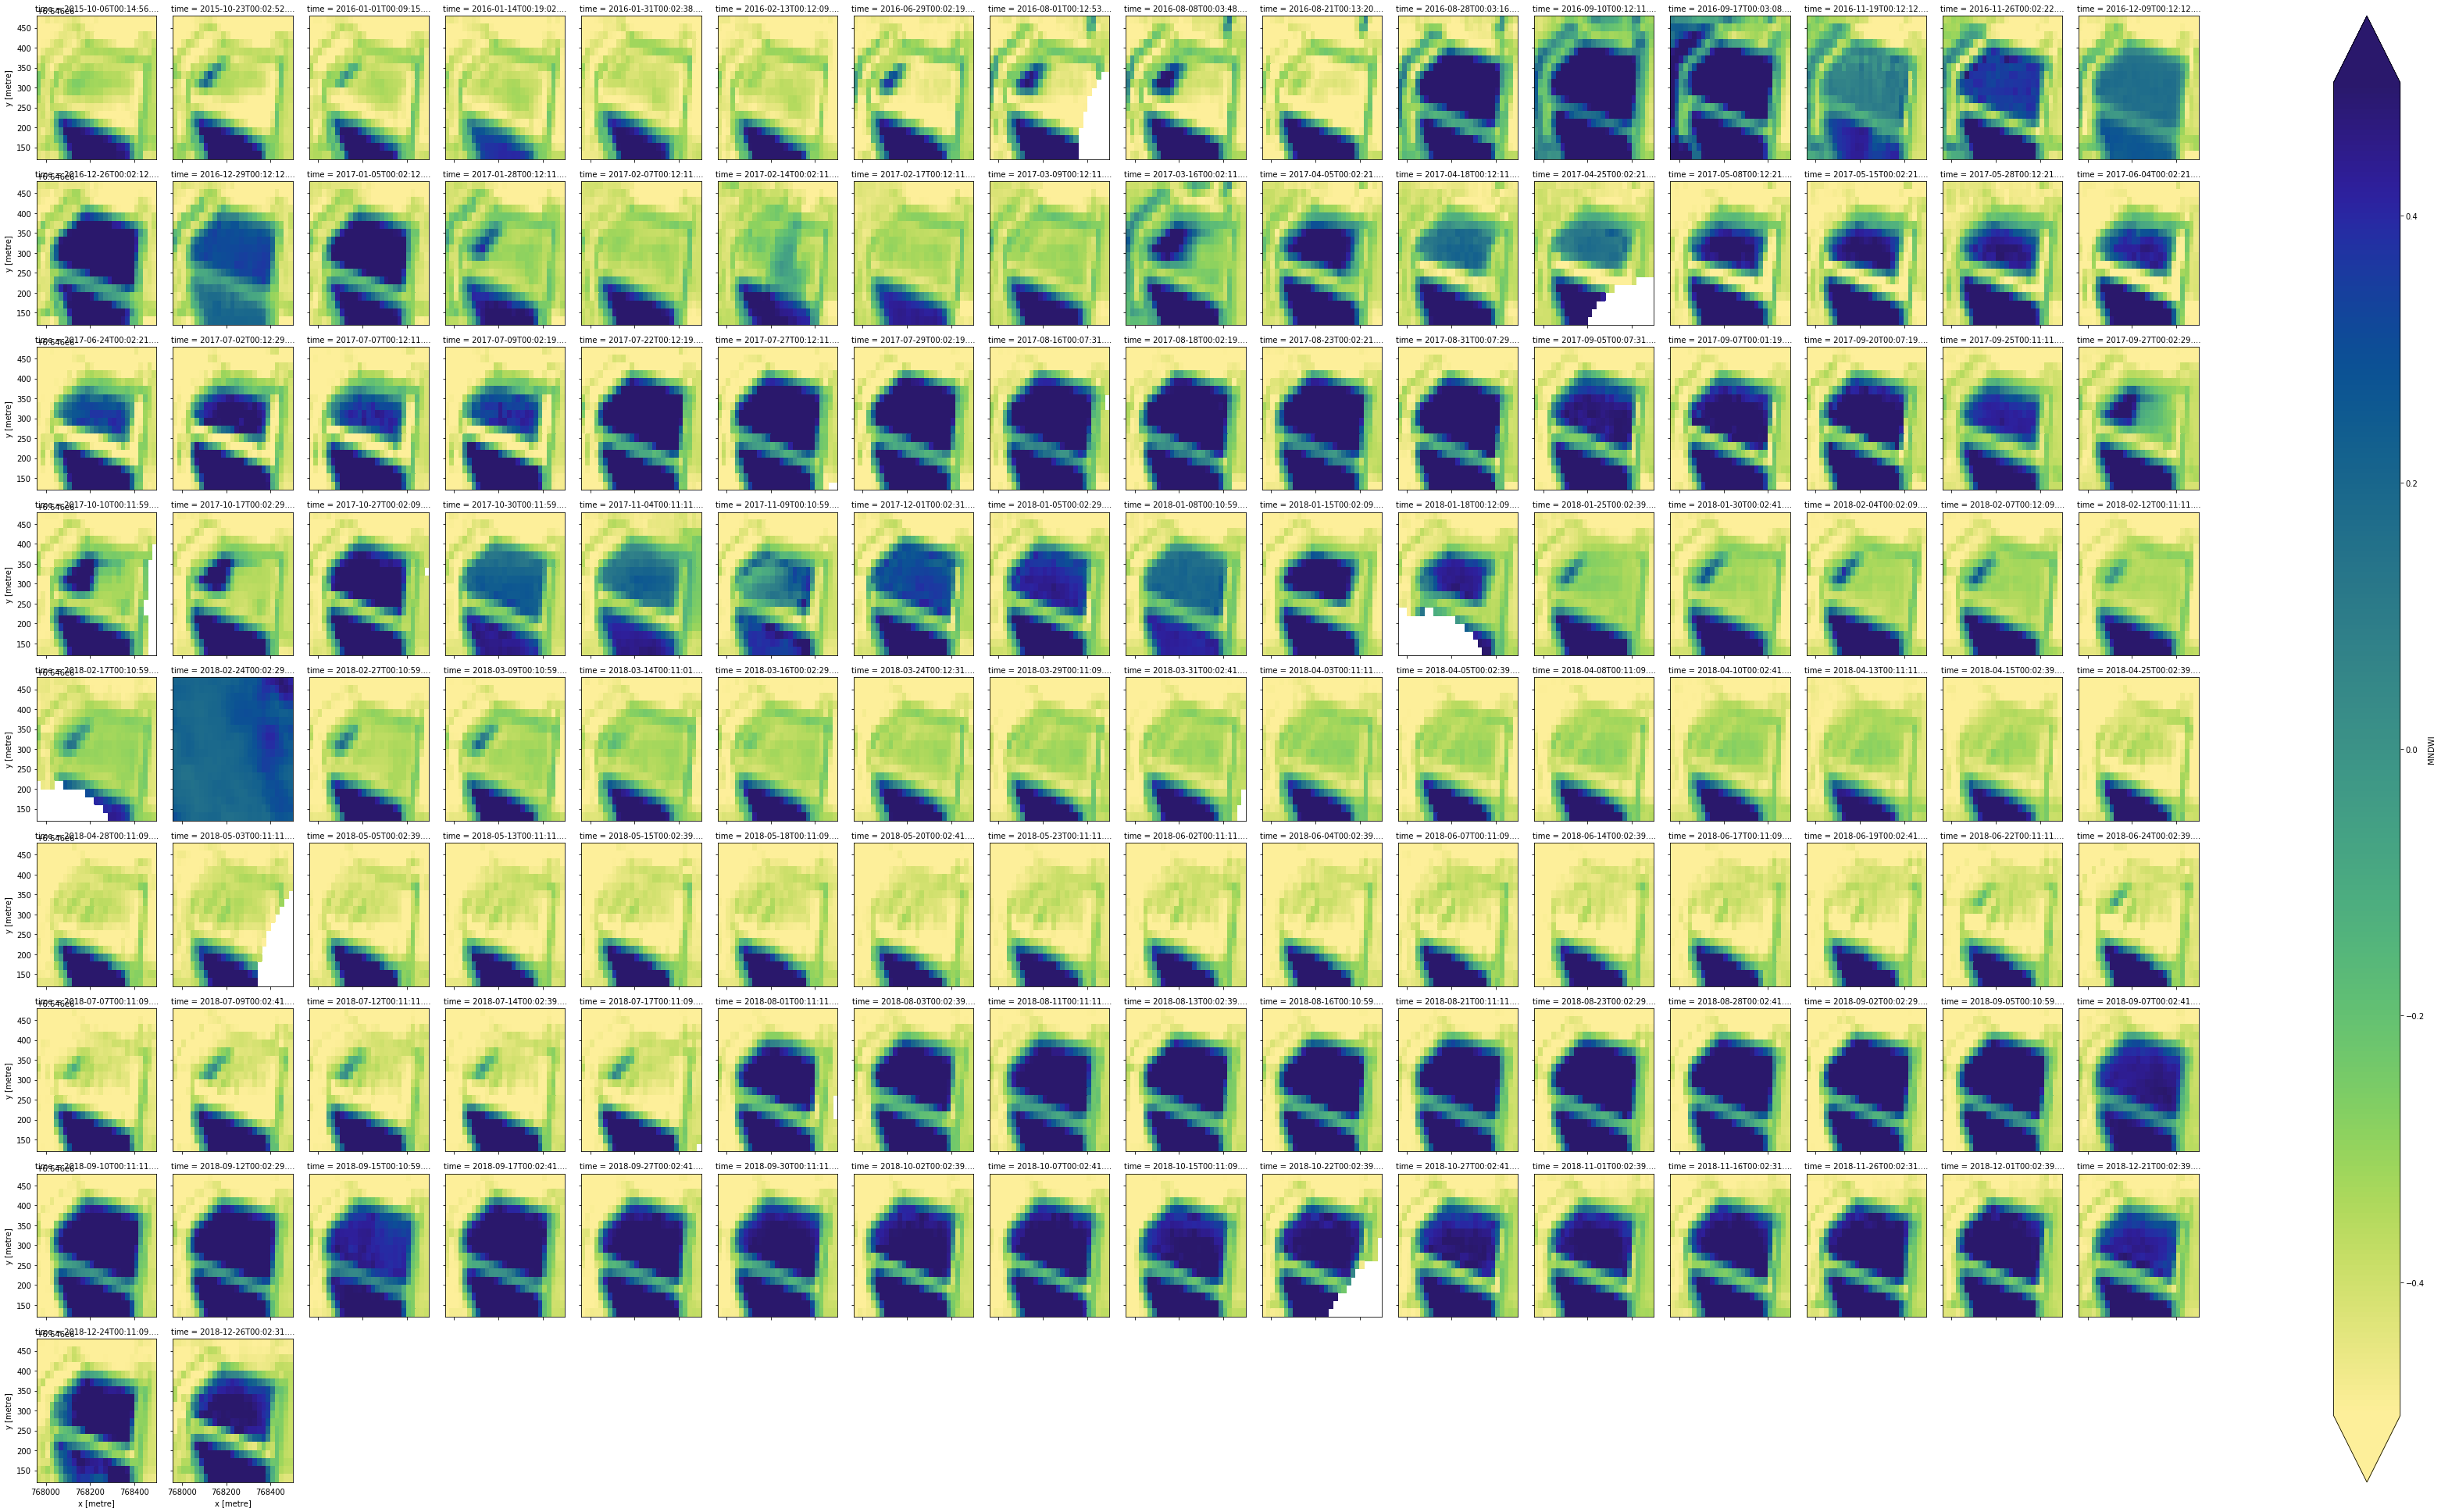

In [142]:
# Get spatial extent bounds from dimensions of LiDAR data
ymin = lidar_subset.y.min().item()
ymax = lidar_subset.y.max().item()
xmin = lidar_subset.x.min().item()
xmax = lidar_subset.x.max().item()

query = {'x': (xmin, xmax),
         'y': (ymax, ymin),
         'crs':'EPSG:28355',
         'time': ('2015-01-01', '2019-03-31'),
         'resolution': (-20, 20),
         'output_crs': 'EPSG:28355',
         'resampling':'bilinear', 
         # 'limit':20
        }

# Load in only Sentinel 2 observations with less than X percent clear pixels
minimum_cloudfree_perc = 0.8
satellite_ds = DEADataHandling.load_clearsentinel2(dc=dc, query=query,
                                                   sensors=['s2a', 's2b'],
                                                   bands_of_interest=['nbart_green', 'nbart_swir_2'],    
                                                   masked_prop=minimum_cloudfree_perc,
                                                   mask_pixel_quality=True,
                                                   mask_invalid_data=True)

# Compute Modified Normalised Difference Water Index
satellite_ds['MNDWI'] = (satellite_ds.nbart_green - satellite_ds.nbart_swir_2) / (satellite_ds.nbart_green + satellite_ds.nbart_swir_2)

# Preview result
satellite_ds.MNDWI.plot(col='time', col_wrap=16, vmin=-0.5, vmax=0.5, cmap=cmocean.cm.haline_r)

## Extract waterline boundaries

Operating in single z-value, multiple arrays mode
Exporting contour shapefile to output_data/test3_waterlines.shp


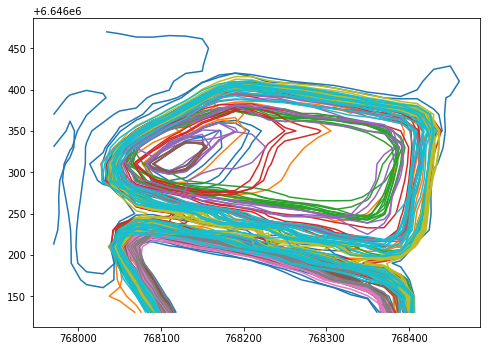

In [147]:
# Add date metadata to each extracted waterline
custom_attrs = {'date': [str(i)[0:10] for i in satellite_ds.time.values]}
custom_attrs_dtypes = {'date': 'str'}

# Extract waterline contours for the supplied water index threshold:
contour_gdf = SpatialTools.contour_extract(z_values=[0.0],
                                           ds_array=satellite_ds.MNDWI,
                                           ds_crs=satellite_ds.crs,
                                           ds_affine=satellite_ds.affine,
                                           output_shp=f'output_data/{name}_waterlines.shp',
                                           attribute_data=custom_attrs,
                                           attribute_dtypes=custom_attrs_dtypes,
                                           min_vertices=10,
                                           verbose=False)

# Re-project contour to ensure CRS matches waterbody polygon and LiDAR
contour_gdf = contour_gdf.to_crs(polygon_gdf.crs)

# Clip contours to extent of waterbody polygon. This prevents the waterlines 
# including portions of neighbouring waterbodies or surrounding naturally wet
# terrain, which would introduce uncertainty into extracted water level estimates.
# Because this may delete some contours entirely, we then filter to keep only
# contours that have data after the clip.
contour_gdf.plot(figsize=(8,8), column='date')

## Extract median and standard deviation water levels from LiDAR

In [139]:
%load_ext line_profiler

contour_gdf['geometry'] = contour_gdf.intersection(polygon_gdf.unary_union)
contour_gdf = contour_gdf[[True if i else False for i in contour_gdf.geometry]]


# def get_water_level(x, dem, x_offsets=[-20, -13.33, -6.66, 0, 6.66, 13.33, 20], y_offsets=[-20, -13.33, -6.66, 0, 6.66, 13.33, 20]):  
def get_water_level(x, dem, x_offsets=[-10, -5, 0, 5, 10], y_offsets=[-10, -5, 0, 5, 10]):  
# def get_water_level(x, dem, x_offsets=[0], y_offsets=[0]):  
    
    try: 
        xx, yy = x.geometry.coords.xy
        xx = np.array(xx)
        yy = np.array(yy)

    except:

        xx = np.concatenate([i.coords.xy[0] for i in x.geometry])
        yy = np.concatenate([i.coords.xy[1] for i in x.geometry]) 
        
    xx = xr.DataArray(xx, dims='z')
    yy = xr.DataArray(yy, dims='z')
        
    all_offsets = []    

    for x_offset, y_offset in itertools.product(x_offsets, y_offsets):        

        sampled_elevs = dem.interp(x=xx + x_offset, y=yy + y_offset).values

        all_offsets.append(((x_offset, y_offset, np.nanmedian(sampled_elevs), np.nanstd(sampled_elevs))))

    # From the dataframe of resulting water_levels and water_level_stds for different xy offsets, 
    # select the row with the lowest standard deviation in elevation values.
    offset_df = pd.DataFrame(all_offsets, columns=['x_offset', 'y_offset', 'water_level', 'water_level_std'])
    offset_min_std = offset_df.iloc[offset_df.water_level_std.argmin()]

    return offset_min_std 

# %lprun -f get_water_level contour_gdf.apply(lambda x: get_water_level(x, lidar_subset), axis = 1)

# Extract elevations and take median for each contour
contour_gdf[['x_offset', 'y_offset', 'water_level', 'water_level_std']] = contour_gdf.apply(lambda x: get_water_level(x, lidar_subset), axis = 1)
# contour_gdf.head()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


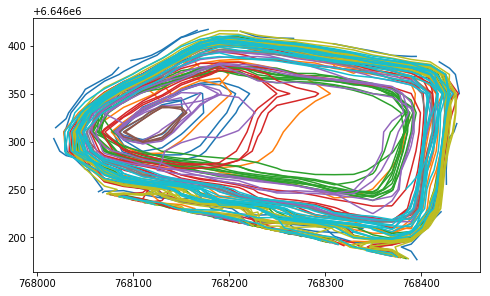

In [148]:
# %load_ext line_profiler
import shapely
from shapely.geometry import LineString

# def get_water_level(x, dem, x_offsets=[-10, -5, 0, 5, 10], y_offsets=[-10, -5, 0, 5, 10], poly=polygon_gdf):      
def get_water_level(x, dem, x_offsets=[0], y_offsets=[0], poly=polygon_gdf):  
       
    all_offsets = []    

    for x_offset, y_offset in itertools.product(x_offsets, y_offsets):  
        
        # Shift polygon by offset amount
        new_geom = shapely.affinity.translate(x.geometry, xoff=x_offset, yoff=y_offset)
        
        # Clip to extents
        new_geom = new_geom.intersection(poly.unary_union)
        
        try:
        
            if isinstance(new_geom, LineString):
                xx, yy = new_geom.coords.xy
                xx = np.array(xx)
                yy = np.array(yy)

            else:

                xx = np.concatenate([i.coords.xy[0] for i in new_geom])
                yy = np.concatenate([i.coords.xy[1] for i in new_geom]) 

            xx = xr.DataArray(xx, dims='z')
            yy = xr.DataArray(yy, dims='z')

            sampled_elevs = dem.interp(x=xx, y=yy).values

            all_offsets.append(((new_geom, x_offset, y_offset, np.nanmedian(sampled_elevs), np.nanstd(sampled_elevs))))
            
        except:
            
            all_offsets.append(((np.nan, x_offset, y_offset, 0, 0)))

    # From the dataframe of resulting water_levels and water_level_stds for different xy offsets, 
    # select the row with the lowest standard deviation in elevation values.
    offset_df = pd.DataFrame(all_offsets, columns=['geometry', 'x_offset', 'y_offset', 'water_level', 'water_level_std'])
    offset_min_std = offset_df.iloc[offset_df.water_level_std.argmin()]

    return offset_min_std 

# %lprun -f get_water_level print(contour_gdf.apply(lambda x: get_water_level(x, lidar_subset), axis = 1))

# Extract elevations and take median for each contour
contour_gdf[['geometry', 'x_offset', 'y_offset', 'water_level', 'water_level_std']] = contour_gdf.apply(lambda x: get_water_level(x, lidar_subset), axis = 1)
contour_gdf.plot(figsize=(8,8), column='date')
# contour_gdf.head()

## Convert water levels to volumes for each timestep

In [149]:
# Get volume from heights
contour_gdf['volume'] = contour_gdf.apply(lambda x: level_to_volume(x.water_level, dem=lidar_masked)[1], axis=1)
contour_gdf['volume_min'] = contour_gdf.apply(lambda x: level_to_volume(x.water_level - x.water_level_std, dem=lidar_masked)[1], axis=1)
contour_gdf['volume_max'] = contour_gdf.apply(lambda x: level_to_volume(x.water_level + x.water_level_std, dem=lidar_masked)[1], axis=1)

# Add missing 0 volume timesteps by comparing set of dates in the contour file to the dates in the original satellite data
missing_dates = set(str(i)[0:10] for i in satellite_ds.time.values) - set(contour_gdf.date)
missing_data = pd.DataFrame(np.zeros(shape=(len(missing_dates), 3)), index=missing_dates, columns=['volume', 'volume_min', 'volume_max'])
contour_gdf = pd.concat([contour_gdf.set_index('date'), missing_data], sort = False).sort_index()

# Drop any 0 volume timestep that is completely surrounded by two timesteps with volumes > the lowest 10% 
# of all volumes, as these observations are likely to be invalid (e.g. water surface obscured by unmarked cloud etc)
shifted_test = ((contour_gdf.volume.shift(1, fill_value=1) > contour_gdf.volume.quantile(0.1)) & 
                (contour_gdf.volume.shift(-1, fill_value=1) > contour_gdf.volume.quantile(0.1)))
contour_gdf = contour_gdf[~((contour_gdf.volume == 0) & shifted_test)]

# Make dataframe index time-aware
contour_gdf.index = pd.DatetimeIndex(contour_gdf.index)
contour_gdf.head()


,geometry,x_offset,y_offset,water_level,water_level_std,volume,volume_min,volume_max
2015-10-23,LINESTRING (768129.9999999988 6646307.52971111...,0.0,0.0,213.271868,0.048008,0.039751,0.001186,0.168737
2016-01-01,NaN,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-14,NaN,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-31,NaN,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2016-02-13,NaN,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


## Plot volume time series

Average standard deviation of water level: 0.54 m



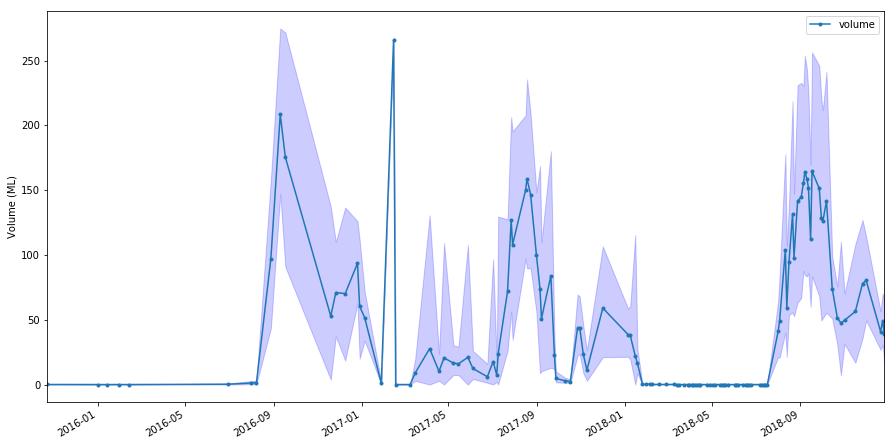

In [150]:
contour_gdf[['volume']].plot(figsize=(15, 8), style='-o', ms=3)
plt.gca().set_ylabel("Volume (ML)")
plt.fill_between(contour_gdf.index, contour_gdf.volume_min, contour_gdf.volume_max, color='b', alpha=0.2)
print(f'Average standard deviation of water level: {contour_gdf.water_level_std.mean():.{2}f} m\n')

In [ ]:
contour_gdf.sort_values('volume', ascending=True).plot(figsize=(14,14), column='volume')

In [ ]:
contour_gdf.dropna(subset=['geometry']).to_file(f'output_data/{name}_waterlines_offset.shp')

In [ ]:
contour_gdf_adj = contour_gdf.dropna(subset=['geometry']).copy()
# contour_gdf_adj.to_file(f'output_data/test_contours_vol.shp')
contour_gdf_adj['geometry'] = contour_gdf_adj.apply(lambda x: shapely.affinity.translate(x.geometry, xoff=x.x_offset, yoff=x.y_offset), axis=1)
contour_gdf_adj.sort_values('volume', ascending=True).plot(figsize=(14,14), column='volume')

In [ ]:
contour_gdf.tail(20)